<img src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" style="width:256px" > <img src="https://upload.wikimedia.org/wikipedia/commons/1/12/Cc-by-nc-sa_icon.svg" width=192 align=right>

**Author :** Jean-Christophe Loiseau

**Email :** [jean-christophe.loiseau@ensam.eu](mailto:jean-christophe.loiseau@ensam.eu)

**Date :** June 2025

---

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.linalg import toeplitz, hankel

# **Linear System Identification**

## **Introduction**

In this notebook, we will look at *linear system identification*, with a particular emphasis on [subspace identification](https://en.wikipedia.org/wiki/Subspace_identification_method). Many different techniques fall under this umbrella, including the [Eigensystem realization algorithm](https://en.wikipedia.org/wiki/Eigensystem_realization_algorithm) (ERA) by [Juang & Pappa](https://arc.aiaa.org/doi/10.2514/3.20031) (1984), N4SID by [Van Overschee & De Moor](https://www.sciencedirect.com/science/article/abs/pii/0005109894902305) (1994), MOESP by [Verhaegan](https://www.sciencedirect.com/science/article/abs/pii/0005109894902291) (1994), or CVA by [Larimore](https://ieeexplore.ieee.org/document/203665/) (1990). All of these aim at finding a set of matrices representing a linear-time-invariant (LTI) system solely from input-output data.

### **A quick review about LTI systems**

Before getting to the meat of the problem, let us make sure we're all on the same page and review some fundamental concepts of LTI systems. For that purpose, we'll consider the following set of equations

$$
\begin{aligned}
    x_{t+1} & = A x_t + B u_t \\
    y_t & = C x_t + D u_t,
\end{aligned}
$$

where $x \in \mathbb{R}^n$ is the *state vector* of the system with $n$ degrees of freedom, $u \in \mathbb{R}^p$ is the *input vector* with $p$ channels, and $y \in \mathbb{R}^q$ is the *output vector* with $q$ measurements. The $n \times n$ matrix $A$ is the *transition matrix*. It describes the natural dynamics of the system. The $n \times p$ and $q \times n$ matrices $B$ and $C$ are the *input-to-state* and *state-to-output* matrices. They describe how an input influence the evolution of the state and the type of measurements we make, respectively. Without loss of generality, we will consider only *single-input/single-output* (SISO) systems for the sake of simplicity.

#### **The observability and controllability matrices**

Observability and controllability (or reachability) are two fundamental concepts in LTI system theory which play a pivotal role in system identification.

##### **Is our system observable?**

Most real-life applications are described by *under-sensed* systems, i.e. systems for which we have fewer sensors than degrees of freedom. A natural question thus is

> Can we uniquely determine the initial state of the system if we collect a long enough time series of measurements?

The answer to this question naturally gives rise to the concept of [observability](https://en.wikipedia.org/wiki/Observability). Note that, for a deterministic system, any measurement time-series $\left\{ y_0, y_1, \cdots, y_{\tau-1} \right\}$ can be expressed as

$$
\begin{bmatrix}
y_0 \\ y_1 \\ \cdots \\ y_{\tau}
\end{bmatrix}
=
\begin{bmatrix}
C \\ CA \\ \cdots \\ CA^{\tau-1}
\end{bmatrix}
x_0.
$$

You can easily convince yourself that, for $\tau$ large enough, the above linear system is *over-determined*. We can thus formulate the following *linear least-squares* problem to find $x_0$

$$
\mathrm{minimize} \quad \dfrac12 \Bigg\Vert \begin{bmatrix} C \\ CA \\ \cdots \\ CA^{\tau-1} \end{bmatrix} x_0 -  \begin{bmatrix} y_0 \\ y_1 \\ \cdots \\ y_{\tau-1} \end{bmatrix} \Bigg\Vert_2^2
$$

This problem is *convex* and can be solved analytically. It is moreover *strictly convex*, and thus admits a unique solution, provided the matrix generated by the pair $(A, C)$ has full column-rank. The matrix

$$
\mathcal{O}_{\tau}
=
\begin{bmatrix}
C \\ CA \\ \cdots \\ CA^{\tau - 1}
\end{bmatrix}
$$

is known as the $\tau$-*observability* matrix. The integer value $\tau$ for which $\mathcal{O}_{\tau}$ has full column-rank is the *observability index* (or *lag*) of the system. It can be shown that $\tau \leq n$. If, for $\tau = n$, the observability matrix $\mathcal{O}_{\tau}$ still is rank-deficient, then it will be for all $\tau$ and the system is *unobservable*. In this case, there are at least two initial conditions giving rise to exact same measurement time-series and one cannot disambiguate which of these two initial conditions generated these measurements.

##### **Is our system controllable?**

The dual of the observability is known as the *controllability*. When controlling a system, a natural question is

> Assuming the system is initially at rest (i.e. $x_0 = 0$), does there exist an input sequence $\left\{ u_0, u_1, \cdots, u_{\tau} \right\}$ such that it drives the system to an arbitrary desired state $x_{\mathrm{des}}$ (with $\tau$ as large as needed)?

If such as sequence exists for every abitrary $x_{\mathrm{des}}$, the system is *controllable*. If not, it is *uncontrollable*.

From the equations of the system, we can write

$$
x_{\mathrm{des}} = \begin{bmatrix} A^{\tau-1}B & \cdots & AB & B \end{bmatrix} \begin{bmatrix} u_0 \\ \vdots \\ u_{\tau-2} \\ u_{\tau-1} \end{bmatrix}.
$$

While the observability problem lead to an over-determined system, the controllability is characterized by an *under-determined* one. Clearly, the above system admits a solution provided $x_{\mathrm{des}}$ is in the column-span of the matrix. Moreover, since we are interested in an abitrary $x_{\mathrm{des}}$, this matrix needs to have rank $n$. If so, the system is *controllable*. If not, it is uncontrollable. As before, the integer value $\tau$ for which this matrix is full rank (if it ever becomes full rank) is known as the *controllability index* of the system.

In the rest of this notebook, we will use the following notations

$$
\Delta_{\tau} = \begin{bmatrix} A^{\tau-1}B & \cdots & AB & B \end{bmatrix}
$$

for the *reversed controllability matrix* and

$$
\mathcal{C}_{\tau} = \begin{bmatrix} B & AB & \cdots & A^{\tau-1}B \end{bmatrix}
$$

for the *controllability matrix*. Note that $\Delta_{\tau}$ and $\mathcal{C}_{\tau}$ are related by a simple permutation of the (block-)columns.

#### **The causal convolution and Hankel operators**

The causal convolution and Hankel operators to be defined shortly are just as important as the observability and controllability matrices. One particularly important property of these two operators however is that they can easily be estimated from input-output data, even if the system $(A, B, C, D)$ is unknown, a particularly interesting advantage in experimental settings.

##### **The convolution operator**

Consider once again the LTI system

$$
\begin{aligned}
    x_{t+1} & = Ax_t + Bu_t \\
    y_t & = Cx_t + Du_t
\end{aligned}
$$

and suppose it is initially at rest, i.e. $x_0 = 0$. Consider now an input sequence $\left\{ u_0, u_1, \cdots, u_{\tau} \right\}$. The linear map from this input sequence to the corresponding output sequence is given by

$$
\begin{bmatrix}
y_0 \\ y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_{\tau - 1}
\end{bmatrix}
=
\begin{bmatrix}
D \\
CB & D \\
CAB & CB & D \\
CA^2B & CAB & CB & D \\
\vdots \\
CA^{\tau-1}B & CA^{\tau-2}B & \cdots & CAB & CB & D
\end{bmatrix}
\begin{bmatrix}
u_0 \\ u_1 \\ u_2 \\ u_3 \\ \vdots \\ u_{\tau - 1}
\end{bmatrix}
$$

This matrix $\mathcal{T}$ is the *convolution operator* associated to the system we consider. Its (block-) Toeplitz structure encodes the *linear time invariance* property of the system, while its (block-) lower triangular structure encodes the *causality*. Note that all LTI systems can be described by such a convolution model. Yet, only systems for which this operator is lower triangular are causal and thus admit a state-space representation $(A, B, C, D)$. For such causal systems, the first column of this matrix simply is the *impulse response* of the system. It should be emphasized that, while it formally is an infinite-dimensional operator, the infinite impulse response of many stable physical systems decreases sufficiently rapidly in time such that it can be well approximated by a finite impulse response filter and thus a finite dimensional matrix.

##### **The Hankel operator**

A closely related operator is the *Hankel operator*. While the convolution one maps $\left\{u_0, u_1, \cdots, u_{\tau-1}, \cdots \right\}$ to $\left\{y_0, y_1, \cdots, y_{\tau-1} , \cdots \right\}$, the Hankel operator maps the (past) input sequence $\left\{u_{-\tau} , u_{-\tau+1} , \cdots u_{-1}, \cdots \right\}$ to the (future) output sequence $\left\{y_0, y_1, \cdots, y_{\tau-1}, \cdots \right\}$. It is given by

$$
\mathcal{H}
=
\begin{bmatrix}
CB & CAB & CA^2B & \cdots \\
CAB & CA^2 B & CA^3 B & \cdots \\
CA^2B & CA^3B & CA^4B & \cdots \\
\vdots
\end{bmatrix}.
$$

Eventhough it is an infinite dimensional linear operator, it nonetheless has a finite rank. Indeed, it can easily be rewritten as

$$
\mathcal{H}
=
\begin{bmatrix}
C \\ CA \\ CA^2 \\ \vdots
\end{bmatrix}
\begin{bmatrix}
B & AB & A^2B & \cdots
\end{bmatrix},
$$

i.e. as the outer product of the infinite-time (yet finite rank) observability and controllability matrices. Note moreover that, just like its convolution counterpart, the Hankel operator can be directly constructed from the impulse response of the system, and thus from experimental data. Provided such an impulse response has been measured (or estimated), one can construct a finite-dimensional approximation of this Hankel operator and determine the number of degrees of freedom of the system (or its jointly observable and controllable subsystem to be exact) from the singular value decomposition of $\mathcal{H}$. This is at the core of the *Eigensystem Realization Algorithm* (ERA) that we'll discuss later.

#### **The extended state space model**

If you ever need to conduct a linear system identification analysis, you are then in the situation where not only $(A, B, C, D)$ are unknown but also the state sequence $\left\{ x_0, x_1, \cdots \right\}$ (and its dimension). Given only input-output data, it would thus be advantageous to rewrite the whole system evolution equations solely in terms of these.

Suppose for now that we now the initial condition $x_0$. Then, the resulting state sequences continues as follows

$$
x_1 = Ax_0 + Bu_0, \quad x_2 = Ax_1 + Bu_1, \quad x_3 = Ax_2 + Bu_2, \quad x_4 = Ax_3 + Bu_3.
$$

Alternatively, we could also write $x_3$ and $x_3$ as

$$
x_3 = A^2x_1 + ABu_1 + Bu_2, \quad \text{and} \quad x_4 = A^2 x_2 + ABu_2 + Bu_3,
$$

and thus

$$
\begin{bmatrix}
    x_3 & x_4
\end{bmatrix}
=
A^2
\begin{bmatrix}
    x_1 & x_2
\end{bmatrix}
+
\begin{bmatrix}
    AB & B
\end{bmatrix}
\begin{bmatrix}
    u_1 & u_2 \\
    u_2 & u_3
\end{bmatrix}.
$$

It does not seem like we made much progress toward eliminating the internal state but bear with me for another couple of lines. Starting from the measurement equation

$$
y_k = C x_k + D u_k,
$$

we can write

$$
\begin{bmatrix}
    y_k & y_{k+1} \\
    y_{k+1} & y_{k+2}
\end{bmatrix}
=
\begin{bmatrix}
    C \\ CA
\end{bmatrix}
\begin{bmatrix}
    x_k & x_{k+1}
\end{bmatrix}
+
\begin{bmatrix}
    D \\
    CB & D
\end{bmatrix}
\begin{bmatrix}
    u_k & u_{k+1} \\
    u_{k+1} & u_{k+2}
\end{bmatrix}.
$$

Looking at the two equations we've just derived, we can recognize a few operators: the reverse controllability matrix $\Delta_2$, the observability matrix $\mathcal{O}_2$, as well as the convolution operator $\mathcal{T}_2$. Additionally, the matrices constructed from the input-output data appear to have the familiar Hankel structure.

Let us denote the *past* and *future* states sequences as

$$
X_p = \begin{bmatrix} x_1 & x_2 \end{bmatrix},
\quad \text{and} \quad
X_f = \begin{bmatrix} x_3 & x_4 \end{bmatrix}.
$$

Likewise, we'll introduce the following notations for the past/future input-output data matrices

$$
Y_p = \begin{bmatrix} y_1 & y_2 \\ y_2 & y_3 \end{bmatrix}
,\quad Y_f = \begin{bmatrix} y_3 & y_4 \\ y_4 & y_5 \end{bmatrix},
$$

as well as

$$
U_p = \begin{bmatrix} u_1 & u_2 \\ u_2 & u_3 \end{bmatrix}
,\quad U_f = \begin{bmatrix} u_3 & u_4 \\ u_4 & u_5 \end{bmatrix}.
$$

Using these notations, we can write

$$
\begin{aligned}
    X_f & = A^2 X_p + \Delta_2 U_p, \\
    Y_p & = \mathcal{O}_2 X_p + \mathcal{T}_2 U_p \\
    Y_f & = \mathcal{O}_2 X_f + \mathcal{T}_2 U_f.
\end{aligned}
$$

After a bit of algebraic manipulations, one can write the *extended state space model*

$$
Y_f - \mathcal{T}_{2} U_f = \mathcal{O}_{2} A^2 \mathcal{O}_{2}^{\dagger} Y_p + \mathcal{O}_{2} \left( \Delta_{2} - A^2 \mathcal{O}_{2}^{\dagger} \mathcal{T}_{2} \right) U_p,
$$

where $\mathcal{O}^{\dagger}$ denotes the pseudo-inverse. While we restricted ourselves to two time steps to construct both the state sequence and the separation between $X_p$ and $X_f$, this was an arbitrary choice. The most general formulation of the *extended state space model* is

$$
Y_f - \mathcal{T}_{\tau} U_f = \mathcal{O}_{\tau} A^k \mathcal{O}_{\tau}^{\dagger} Y_p + \mathcal{O}_{\tau} \left( \Delta_{\tau} - A^k \mathcal{O}_{\tau}^{\dagger} \mathcal{T}_{\tau} \right) U_p.
$$

Although we have been able to completely eliminate the internal state $x$ of the system, the different operators involved in this extended state space model are unknown since they depend on the unknown system matrices $(A, B, C, D)$. We are however now in a situation where we can formulate various optimization problems to infer these operators and extract out a realization of the unknown system. This is the whole goal of linear system identification.

---

## **Algorithms**

Now that we set the stage, let us illustrate how the different operators can be inferred from input-output and then extract a realization of the unknown system. For that purpose, we will consider the simple mechanical system depicted in the figure below.

**ADD FIGURE**

It is a two-degree-of-freedom system with masses $m_1$ and $m_2$, viscous dashpots $g_1 = g_2 = g$, and stiffnesses $k_1 = k_2 = k$. It is governed by the equation of motion

$$
M \ddot{z} + G \dot{z} + Kz = u,
$$

where

$$
M = \begin{bmatrix} m_1 \\ & m_2 \end{bmatrix}, \quad G = \begin{bmatrix} 2g & -g \\ -g & 2g \end{bmatrix}, \quad \text{and} \quad K = \begin{bmatrix} 2k & -k \\ -k & 2k \end{bmatrix}.
$$

The applied force vector is

$$
u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}.
$$

We'll assume that only that each mass is equipped with a displacement sensor such that the *continuous-time* state-space model reads

$$
\begin{aligned}
    \dot{x} & = A_c x + B_c u \\
    y       & = C x + D u,
\end{aligned}
$$

where

$$
A_c = \begin{bmatrix} 0 & I \\ -M^{-1}K & -M^{-1}G \end{bmatrix},
\quad B_c = \begin{bmatrix} 0 \\ M^{-1} \end{bmatrix},
\quad C = \begin{bmatrix} I & 0 \end{bmatrix}, \quad \text{and} \quad D = 0,
$$

and $x = \begin{bmatrix} z & \dot{z} \end{bmatrix}^T$ is thte state vector. For the sake of simplicity, we'll assume also that only the lighter mass is instrumented (colocated sensor and actuator) so that we effectively have a SISO system.

In the rest of this notebook, we will consider the following set of parameters: $m_1 = 0.8$, $m_2 = 1.5$, $g=0.1$, and $k=10$. The new few cells implement this numerical model using `scipy` and provide various pieces of information about the system (e.g. its amplitude and phase response, impulse response function, etc).

In [2]:
from scipy.signal import lti, lsim, impulse, bode
from scipy.signal import dlti, dlsim, dimpulse, dbode

#> Parameters of the system.
m1, m2, g, k = 0.8, 1.5, 0.1, 10.0

#-----------------------------------------------------
#-----     Continuous-time state space model     -----
#-----------------------------------------------------

#> Mass matrix.
M = np.diag([m1, m2])

#> Stifness matrix.
K = np.array([[2*k, -k], [-k, 2*k]])

#> Viscous matrix.
G = np.array([[2*g, -g], [-g, 2*g]])

#> Dynamics matrix.
Ac = np.block([[np.zeros((2, 2)), np.eye(2)], [-np.linalg.inv(M) @ K, -np.linalg.inv(M) @ G]])
λ, v = np.linalg.eig(Ac)

#> Actuation matrix.
Bc = np.r_[np.zeros((2, 2)), np.linalg.inv(M)]
Bc = Bc[:, 0].reshape(-1, 1) # Only lighter mass is being actuated.

#> Measurement matrix.
C = np.c_[np.eye(2), np.zeros((2, 2))]
C = C[0].reshape(1, -1) # Only lighter mass is being observed.

#> Feedforward matrix.
D = np.zeros((1, 1))

#> Continuous-time plant.
ct_plant = lti(Ac, Bc, C, D)

[(-0.5, 0.5), Text(0, 0.5, 'Impulse response')]

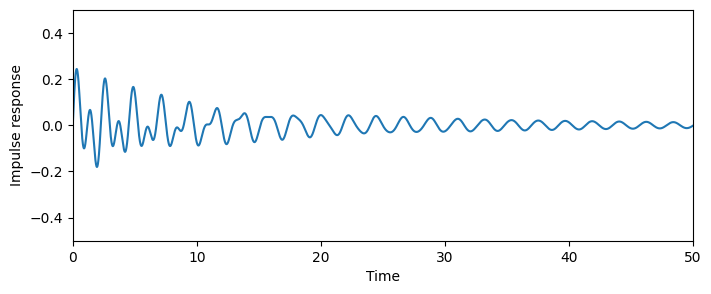

In [3]:
#------------------------------------
#-----     Impulse Response     -----
#------------------------------------

#> Run impulse response simulation.
t = np.linspace(0, 100, 100001)
_, y = impulse(ct_plant, T=t)

#> Plot the IIR.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, y)
ax.set(xlim=(0, 50), xlabel=r"Time")
ax.set(ylim=(-0.5, 0.5), ylabel="Impulse response")

/home/loiseau/miniconda3/envs/cea_saclay/lib/python3.12/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


[(0.0, 1.0), Text(0.5, 0, 'Frequency [Hz]')]

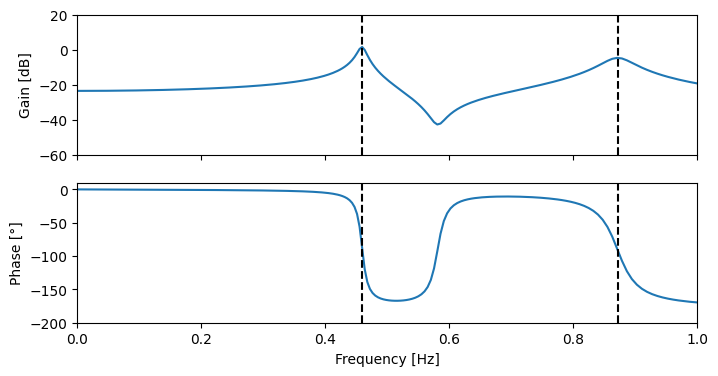

In [4]:
#-----------------------------------------------
#-----     Frequency Response Function     -----
#-----------------------------------------------

#> Range of frequencies for the plot.
ω = np.logspace(-3, 1, 1024)

#> Magnitude and phase.
_, magnitude, φ = bode(ct_plant, w=ω)

#> Plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(ω/(2*np.pi), magnitude)
axes[0].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[0].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[0].set(ylim=(-60, 20), ylabel="Gain [dB]")

axes[1].plot(ω/(2*np.pi), φ)
axes[1].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[1].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[1].set(ylim=(-200, 10), ylabel="Phase [°]")
axes[1].set(xlim=(0, 1), xlabel="Frequency [Hz]")

The figure above depicts the frequency response function of the continuous-time system, in terms of the gain and phase. The vertical dashed lines highlight the two natural frequencies of the system. In the rest of this notebook, our objective will be to identify a discrete-time system $(A, B, C, D)$ having the same impulse and frequency responses that could be used for vibration analysis or control. For that purpose, we will thus discretize the continuous-time system using a [zero-order hold](https://en.wikipedia.org/wiki/Zero-order_hold) method (effectively corresponding to an explicit first-order Euler scheme if you're familiar with numerical methods) with a time-step $\Delta t = 0.01$. Experimentally, this would amount to use a piecewise-constant input signal over a duration of $\Delta t$ and sample the measurements with the same sampling period.

/home/loiseau/miniconda3/envs/cea_saclay/lib/python3.12/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


[(0.0, 1.0), Text(0.5, 0, 'Frequency [Hz]')]

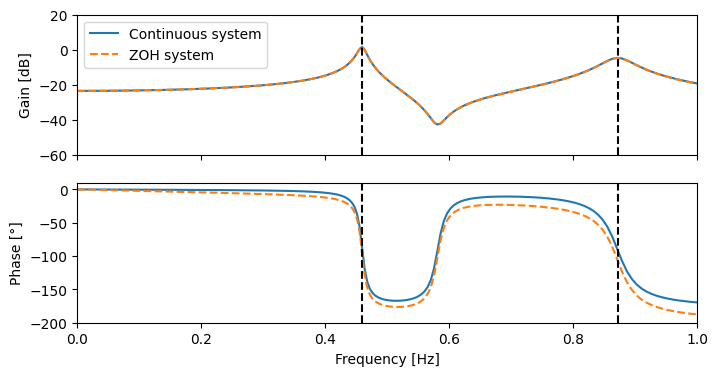

In [5]:
#> Discrete-time plant.
Δt = 0.1 ; fs = 1.0/Δt ; dt_plant = ct_plant.to_discrete(dt=Δt, method="zoh")

#> Bode plot of the discretized system.
z = np.linspace(0, 1, 10240)
ω_discrete, magnitude_discrete, φ_discrete = dt_plant.bode(w=z)

#> Plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(ω/(2*np.pi), magnitude, label="Continuous system")
axes[0].plot(ω_discrete / (2*np.pi), magnitude_discrete, ls="--", label="ZOH system")
axes[0].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[0].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[0].set(ylim=(-60, 20), ylabel="Gain [dB]")
axes[0].legend(loc=0)

axes[1].plot(ω/(2*np.pi), φ)
axes[1].plot(ω_discrete/(2*np.pi), φ_discrete, ls="--")
axes[1].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[1].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[1].set(ylim=(-200, 10), ylabel="Phase [°]")
axes[1].set(xlim=(0, 1), xlabel="Frequency [Hz]")

Looking at this figure, it is clear that the sampling time is sufficiently small so that the frequency response functions of the continuous and ZOH systems are almost indistinguishable. In the rest of this notebook, we will thus the ZOH system as it is quite representative of how data can be gathered experimentally. Its pulse response function (i.e. the discrete-time equivalent of the impulse one) is depicted below.

[(-0.5, 0.5), Text(0, 0.5, 'Pulse response x 20')]

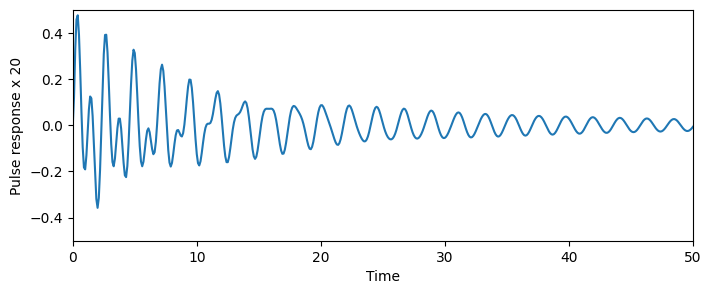

In [6]:
t = np.arange(0, 1001) * Δt
_, prf = dt_plant.impulse(t=t) ; prf = prf[0].flatten()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, prf*20)
ax.set(xlim=(0, 50), xlabel=r"Time")
ax.set(ylim=(-0.5, 0.5), ylabel="Pulse response x 20")

### **Eigenrealization Algorithm**

The first algorithm considered is the [Eigensystem realization algorithm](https://en.wikipedia.org/wiki/Eigensystem_realization_algorithm) (ERA) by [Juang & Pappa](https://arc.aiaa.org/doi/10.2514/3.20031) (1984). It is a simple yet effective algorithm whose resulting realization has been related to the reduced-order model obtained from balanced truncation by [Rowley et al.]() (20??). We do need to make a very important practical assumption though

> To use ERA, you need to know before hand the impulse response function of the system!

Experimentally, performing an impulse response experiment essentially amounts to hitting really hard your experimental setup with a hammer. Not a good idea in general... As a consequence, ERA is often used as a post-processing method after the impulse response has been inferred from more acceptable experimental campaigns. But why is the impulse response so important?

Let us consider once again our LTI setup

$$
\begin{aligned}
    x_{t+1} & = Ax_t + Bu_t \\
    y_t & = Cx_t + Du_t.
\end{aligned}
$$

An impulse input sequence reads $\left\{ u_0, u_1, u_2, \cdots \right\} = \left\{ 1, 0, 0, \cdots \right\}$. Using such an impulse, the corresponding output sequence reads

$$
\begin{aligned}
    y_0 & = D \\
    y_1 & = CB \\
    y_2 & = CAB \\
    y_3 & = CA^2B \\
    y_4 & = CA^3B \\
    \vdots
\end{aligned}
$$

You can easily pick up the pattern. Note that the feedforward matrix $D$ is readily available from this impulse response. We thus "only" need to extract the matrices $A, B$, and $C$. Let us now construct a Hankel matrix with the sequence $\left\{ y_1, y_2, \cdots \right\}$. This matrix reads

$$
H
=
\begin{bmatrix}
    y_1 & y_2 & y_3 & \cdots \\
    y_2 & y_3 & y_4 & \cdots \\
    y_3 & y_4 & y_5 & \cdots \\
    \vdots
\end{bmatrix}.
$$

Plugging in the the recurrence relations, we obtain

$$
H
=
\begin{bmatrix}
    CB & CAB & CA^2B & \cdots \\
    CAB & CA^2B & CA^3B & \cdots \\
    CA^2B & CA^3B & CA^4B & \cdots \\
    \vdots
\end{bmatrix}.
$$

Note that this is nothing but a finite-dimensional approximation of the *Hankel operator* $\mathcal{H}$. As such, the matrix $H$ can be factorized as

$$
H
=
\begin{bmatrix}
    C \\ CA \\ CA^2 \\ \vdots \\ CA^{\tau-1}B
\end{bmatrix}
\begin{bmatrix}
    B & AB & A^2B & \cdots & A^{\tau-1}B
\end{bmatrix}
=
\mathcal{O}_{\tau} \mathcal{C}_{\tau}.
$$

Such a factorization can be obtained from the singular value decomposition of $H = U \Sigma V^T$.
The number of non-zero singular values (i.e. the rank of $H$) corresponds to the number of degrees of freedom of the unknown system.
Moreover, the $\tau$-observability and controllability matrices can then be constructed as

$$
\mathcal{O}_{\tau} = U\Sigma^{\frac12}, \quad \text{and} \quad \mathcal{C}_{\tau} = \Sigma^{\frac12} V^T.
$$

Note that the splitting of $\Sigma$ is arbitrary but leads to a so-called *balanced realization* (i.e. a realization for which the observability and controllability gramians are equals and diagonal). From these expressions, we can easily extract $B$ and $C$ as the first $p$ columns of $\mathcal{C}_{\tau} = \Sigma^{\frac12} V^T$ and $q$ rows of $\mathcal{O}_{\tau} = U \Sigma^{\frac12}$, respectively. So far, we have thus been able to extract $B, C$, and $D$ and are thus left with finding $A$.

Three different approaches can be used for that purpose. The first one is based on the construction of a second Hankel matrix from the output sequence $\left\{ y_2, y_3, \cdots \right\}$. Constructing and factorizing this matrix leads to

$$
\bar{H}
=
\begin{bmatrix}
    C \\ CA \\ CA^2 \\ \vdots \\ CA^{\tau-1}
\end{bmatrix}
A
\begin{bmatrix}
    B & AB & A^2B & \cdots & A^{\tau-1}B
\end{bmatrix}
=
\mathcal{O}_{\tau} A \mathcal{C}_{\tau}.
$$

The matrix $A$ can then be extracted as

$$
\begin{aligned}
    A & = \mathcal{O}_{\tau}^{\dagger} \bar{H} \mathcal{C}_{\tau}^{\dagger} \\
      & = \Sigma^{-\frac12} U^T \bar{H} V \Sigma^{-\frac12}.
\end{aligned}
$$

A second approach uses only the $\tau$-observability matrix by realizing that

$$
\begin{bmatrix}
    CA \\ CA^2 \\ CA^3 \\ \vdots \\ CA^{\tau-1}
\end{bmatrix}
=
\begin{bmatrix}
    C \\ CA \\ CA^2 \\ \vdots \\ CA^{\tau-2}
\end{bmatrix}
A
$$

from which $A$ can be extracted using the pseudo-inverse of the $(\tau-1)$-observability matrix. The third approach relies on the same principle but uses the $\tau$-controllability matrix by realizing that

$$
\begin{bmatrix}
    AB & A^2B & A^3B & \cdots & A^{\tau-1}B
\end{bmatrix}
=
A
\begin{bmatrix}
    B & AB & A^2B & \cdots & A^{\tau-2}B
\end{bmatrix}.
$$

All three approaches lead to the same matrix $A$ and the practical choice of the method is a question of personal taste.

#### Application

Let us now illustrate ERA using our mechanical system example. The following cells provide a simple `numpy`/`scipy` implementation of ERA. For the sake of simplicity, only the SISO version is provided albeit extending it to multiple input and/or multiple output is rather straightforward.

In [9]:
def Hankel(y, nr=200, nc=200):
    """
    Utility function to construct a Hankel matrix.
    """
    return hankel(y[:nr], y[nr:nr+nc])

def ERA(prf, order, nr=200, nc=200, dt=1.0):
    """
    Implementation of the Eigensystem Realization Algorithm for
    SISO systems.
    
    INPUT
    -----
    
    prf : numpy array
          Pulse response function of the discrete-time system.
          
    order : int
            Number of singular values to retain when truncating the Hankel operator.
            
    nr, nc : int, optional
             Number of rows and columns of the Hankel matrix.
             
    dt : float, optional
         Sampling period of the discrete-time system.
         
    OUTPUT
    ------
    
    sys : scipy.signal.dlti
          Realization of the system
          
    S   : numpy array
          Hankel singular values.
    """
    #> Extract the D matrix.
    D = np.array([[prf[0]]])
    
    #> Construct the Hankel matrix.
    H = Hankel(prf[1:], nr=nr, nc=nc)
    
    #> Compute its singular value decomposition.
    U, S, Vt = np.linalg.svd(H)
    
    #> Observability and Controllability matrices.
    Obs = U[:, :order] @ np.diag(np.sqrt(S[:order]))
    Ctrb = np.diag(np.sqrt(S[:order])) @ Vt[:order]
    
    #> Extract the B and C matrices.
    C = Obs[0].reshape(1, -1)
    B = Ctrb[:, 0].reshape(-1, 1)
    
    #> Extract the A matrix.
    A = np.linalg.pinv(Obs[:-1]) @ Obs[1:]
    
    #> Identified system.
    sys = dlti(A, B, C, D, dt=dt)
    
    return sys, S

Let us now turn the crank. This is a simplified setup and we know that a fourth-order system should do.

In [10]:
#> Runs the identification procedure.
order = 4
era_sys, hsvd = ERA(prf, order, dt=Δt)

The identified system is given by the following matrices:

In [11]:
print("Matrix A :\n\n", era_sys.A, "\n")
print("Matrix B :\n\n", era_sys.B, "\n")
print("Matrix C :\n\n", era_sys.C, "\n")
print("Matrix D :\n\n", era_sys.D)

Matrix A :

 [[ 0.95465873  0.28288433 -0.01172808 -0.03282659]
 [-0.28288392  0.95357424  0.03294898  0.00677804]
 [-0.01172822 -0.03294899  0.8470861  -0.51178946]
 [ 0.03282579  0.00677834  0.51178958  0.83495855]] 

Matrix B :

 [[-0.0811533 ]
 [-0.06198142]
 [-0.09786056]
 [ 0.08324525]] 

Matrix C :

 [[-0.0811533   0.06198142 -0.09786056 -0.08324525]] 

Matrix D :

 [[0.]]


To verify that a fourth-order system is a good enough approximation, let us plot the Hankel singular values.

[(0.0, 1.0), Text(0, 0.5, 'Hankel singular values')]

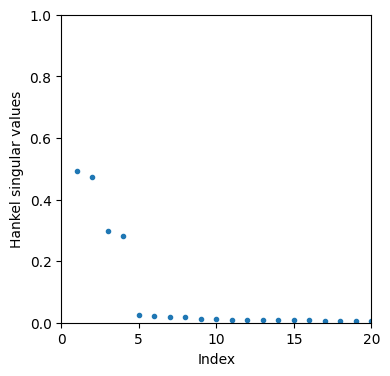

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(np.arange(1, 21), hsvd[:20], ".")
ax.set(xlim=(0, 20), xlabel="Index")
ax.set(ylim=(0, 1.0), ylabel="Hankel singular values")

As expected, a clear drop in the singular value distrubtion can be observed after the fourth one, indicating that the dynamics generating the pulse response function used for the identification problem indeed is generated by a fourth-order system. It needs to be emphasized that it is not always as clear-cut, most notably when the pulse response itself has been identified from data. We can nonetheless estimate the quality of the identified system by comparing its frequency response function with the original continuous-time one.

[(0.0, 1.0), Text(0.5, 0, 'Frequency [Hz]')]

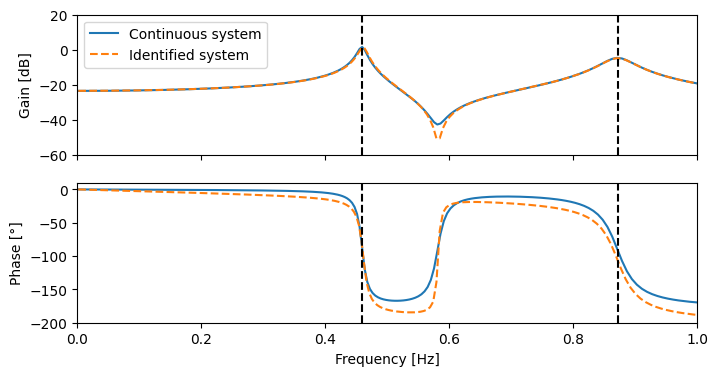

In [13]:
#> Bode plot of the identified system.
ω_discrete, magnitude_discrete, φ_discrete = era_sys.bode(w=ω)

#> Plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(ω/(2*np.pi), magnitude, label="Continuous system")
axes[0].plot(ω_discrete / (2*np.pi), magnitude_discrete, ls="--", label="Identified system")
axes[0].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[0].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[0].set(ylim=(-60, 20), ylabel="Gain [dB]")
axes[0].legend(loc=0)

axes[1].plot(ω/(2*np.pi), φ)
axes[1].plot(ω_discrete/(2*np.pi), φ_discrete, ls="--")
axes[1].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[1].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[1].set(ylim=(-200, 10), ylabel="Phase [°]")
axes[1].set(xlim=(0, 1), xlabel="Frequency [Hz]")

Various control theoretic measures can be used to obtain a more quantitative estimate of how different the identified system is from the true one. To keep things simple, we will however simply use the eye-ball norm and, clearly, in this norm, the two systems have almost the exact same frequency response function. Another thing is to compare the eigenvalues of the two systems. This is done in the plot below.

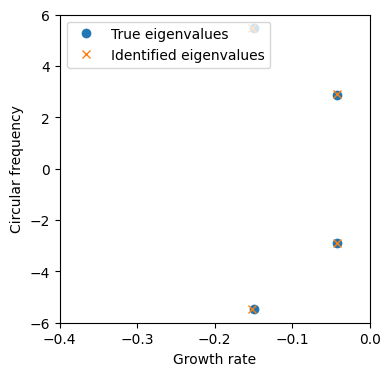

In [14]:
#> Eigenvalues of the original continuous-time system.
λ = np.linalg.eigvals(Ac)

#> Eigenvalues of the identified discrete-time system.
μ = np.linalg.eigvals(era_sys.A)

#> Log-transformation of the discrete-time eigenvalues for comparison.
μ = np.log(μ) / Δt

#> Eigenspectrum.

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(λ.real, λ.imag, "o", label="True eigenvalues")
ax.plot(μ.real, μ.imag, "x", label="Identified eigenvalues")
ax.set(xlim=(-0.4, 0), xlabel="Growth rate")
ax.set(ylim=(-6, 6), ylabel="Circular frequency")
ax.legend(loc="upper left")

Once again, we can see an excellent qualitative and quantitative agreements between the (log-transformed) eigenvalues of the identified discrete-time system and those of the original continuous time one.

### **Unknown impulse response**

As mentionned previously, conducting an impulse response experiment is a rather tricky business which can put a lot of strain (and possibly break) the experimental apparatus. A better alternative thus is to conduct an experiment with a more practical input sequence, record the corresponding output sequence and extract the impulse response (which is nothing but the convolution kernel) from it before post-processing it with ERA. When doing so, the input sequence however needs to have a rich-enough spectral content to excite as many internal vibration modes as possible. We'll say that the input sequence needs to be [persistently exciting](https://arxiv.org/pdf/2303.08707) (or PE in short).

> **Definition:** For $L \in \mathbb{Z}_{>0}$ and $N \geq L$, the sequence $\left\{ u_t \right\}_{t=0}^{N-1}$, with $u_t \in \mathbb{R}^p$, is persistently exciting of order $L$ if $\mathrm{rank}\left(\mathcal{H}_L(u)\right) = pL$, where $\mathcal{H}_L(u)$ is the Hankel matrix with $L$ rows constructed from $\left\{ u_t \right\}_{t=0}^{N-1}$.

Equivalently, we can define the persistent excitation order $L$ using the $n \times n$ Toeplitz matrix constructed from the autocorrelation function of the signal $u_t$, i.e. $R(\tau) = E \left[ u_t u_{t+\tau} \right]$. Then, the P.E. order of the signal is the maximum integer $L$ for which the leading $L \times L$ block of Toeplitz matrix is not rank-deficient. Let us illustrate this using various canonical signals.

**Monochromatic sine wave -** Consider a simple sine wave with frequency $f = 1$ Hz and sampled at a frequency $f_s = 1024$ Hz. Such a signal is depicted in the figure below.

[(-1.2, 1.2), Text(0, 0.5, 'u(t)')]

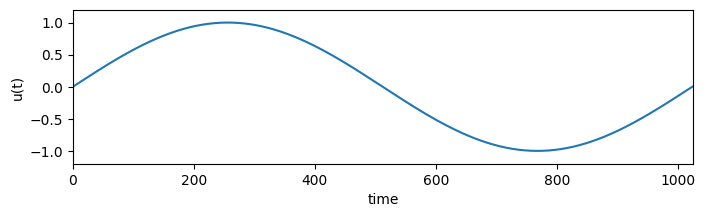

In [15]:
t = np.linspace(0, 1, 1025)
u = np.sin(2*np.pi*t)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(u)
ax.set(xlim=(0, len(t)), xlabel="time")
ax.set(ylim=(-1.2, 1.2), ylabel="u(t)")

It can easily be shown that its autocorrelation is given by 

$$
R(\tau) = \cos(2\pi f \tau) \quad \text{for } \tau \in \mathbb{Z},
$$

which we plot below.

[(-1.2, 1.2), Text(0, 0.5, 'R(τ)')]

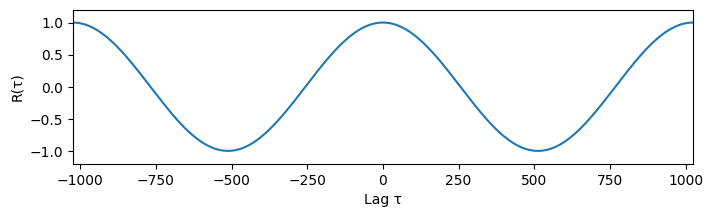

In [16]:
τ = np.arange(-1024, 1025)
R = np.cos(2*np.pi*τ/1024)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(τ, R)
ax.set(xlim=(τ.min(), τ.max()), xlabel="Lag τ")
ax.set(ylim=(-1.2, 1.2), ylabel="R(τ)")

Let us now look at the numerical rank of the leading $L \times L$ block of the corresponding Toeplitz matrix, for increasing $L$. The figure below depicts a heatmap of this correlation matrix.

(-0.5, 2047.5, 2047.5, -0.5)

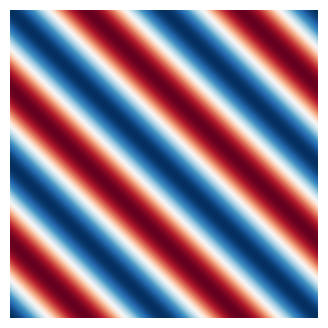

In [17]:
T = toeplitz(R[:2048])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(T, cmap="RdBu")
ax.axis("off")

This is a highly structured Toeplitz matrix. An expert eye might directly identify its rank as being equal to 2. Let us verify this numerically.

[(0.0, 3.0), Text(0, 0.5, 'Numerical rank')]

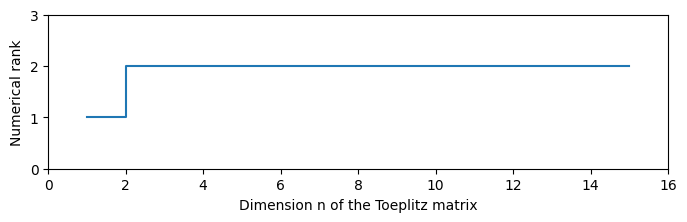

In [18]:
# > Numerical rank of the Toeplitz matrix.
rank = np.array([np.linalg.matrix_rank(toeplitz(R[:i])) for i in range(1, 16)])

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.step(np.arange(1, len(rank)+1), rank, where="post")
ax.set(xlim=(0, 16), xlabel="Dimension n of the Toeplitz matrix")
ax.set(ylim=(0, 3), ylabel="Numerical rank")

It is indeed the case. The $2 \times 2$ leading block has rank 2, but so has the leading $3 \times 3$ one and anyother $n \times n$ block for $n \geq 2$. The monochromatic sine wave thus has a persistent excitation order $L = 2$. Roughly speaking, a signal with P.E order $L$ contains $\frac{L}{2}$ different frequencies. This is also imply that, if such a signal is used for linear system identification, we would at best identify a second-order system whose natural frequency matches that of the input sequence. In general we would thus like to use a signal having a persistent excitation order as large possible.

**Random white noise -** Consider now a $\delta$-correlated white noise with zero mean. Its autocorrelation function is given by

$$
    R(\tau)
    =
    \begin{cases}
        1 \quad \text{if } \tau = 0, \\
        0 \quad \text{otherwise}.
    \end{cases}
$$

The corresponding Toeplitz thus is the identity matrix whose grows with its size. Hence, white noise (whether it is gaussian or not) is persistently exciting signal of *all* orders. Generating such a signal experimentally might however be impractical, most notably for reproducibility purposes, and one may instead use a [pseudorandom binary sequence](https://en.wikipedia.org/wiki/Pseudorandom_binary_sequence) (PRBS) of sufficiently large period to emulate a white noise process, see [here](http://jitkomut.eng.chula.ac.th/ee531/signal.pdf) for more details. Since we are doing things numerically here, we will use a random gaussian white noise for the sake of simplicity but keep this practical issue in mind if you ever have to design an experiment for linear system identification purposes.

#### **Estimating the impulse response from random input/ouput data and post-processing it with ERA**

Now that the issue of the input signal has been addressed, let us consider the problem of estimating the impulse response filter of the system. Suppose that the input sequence $\left\{ u_0, u_1, u_2, \cdots \right\}$ is a persistently exciting signal of sufficiently large order.
Assume furthermore (without loss of practicality) that the system is initially at rest. The response of the system to this input is then the output sequence $\left\{y_0, y_1, y_2, \cdots \right\}$. As discussed earlier, the linear map between the input and output sequence is given by the causal convolution operator and can succintly be written as

$$
\begin{aligned}
y\left[t\right] & = h * u \\
    & = \sum_{\tau = 0}^{\infty} h\left[\tau\right] \ u\left[t - \tau \right],
\end{aligned}
$$

where $\left\{ h_0, h_1, h_2, \cdots \right\}$ is the convolution kernel describing the input-output relationship. Because its expression is the same as that of the response of the system to an impulse sequence, it is known as the *infinite impulse response filter* (IIR filter). For almost every physical systems, we have that $\lim_{\tau \to \infty} \vert h_{\tau} \vert = 0$ such that in practice we can approximate it with a finite impulse response filter (FIR) instead.  The two questions we would need to answer are then

> How long my finite impulse response filter needs to be in order to correctly approximate the infinite impulse response one ?

> How to estimate in practice this FIR filter?

Here we will address only the second one. In its simplest form, the problem we want to solve thus is

$$
\mathrm{minimize} \quad \Vert y - h * u \Vert_2^2
$$

where the Euclidean norm is used out of simplicity. Note that, given a finite-length sequence, this convolution product can be written as a standard matrix-vector product and thus is a standard linear least-squares problem in disguise. This is illustrated below for our test system.

[(-0.2, 0.2), Text(0, 0.5, 'y[t]')]

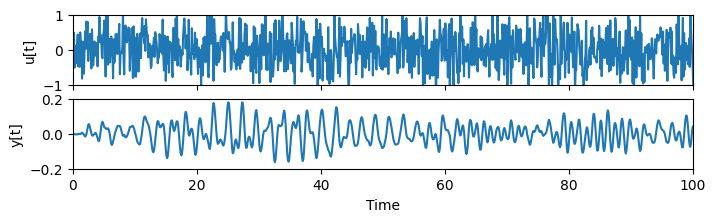

In [19]:
#> Random Gaussian white noise input signal.
t = np.arange(0, 10000)*Δt
u = np.random.randn(len(t)) * 0.5

#> Simulate the response of the continuous-time system.
_, y, _ = lsim(ct_plant, T=t, U=u)

#> Plot the response.
fig, ax = plt.subplots(2, 1, figsize=(8, 2), sharex=True)
ax[0].plot(t, u)
ax[0].set(ylim=(-1, 1), ylabel="u[t]")

ax[1].plot(t, y)
ax[1].set(xlim=(0, 100), xlabel=r"Time")
ax[1].set(ylim=(-0.2, 0.2), ylabel="y[t]")

Let us use this time-series to identify the first 1000 elements of the convolution kernel of the system. This is done below.

Dimensions of the over-determined system :  (10000, 1000)


/tmp/ipykernel_8506/1097680309.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h, *_ = np.linalg.lstsq(T, y)


[(-0.5, 0.5), Text(0, 0.5, 'Pulse response x 20')]

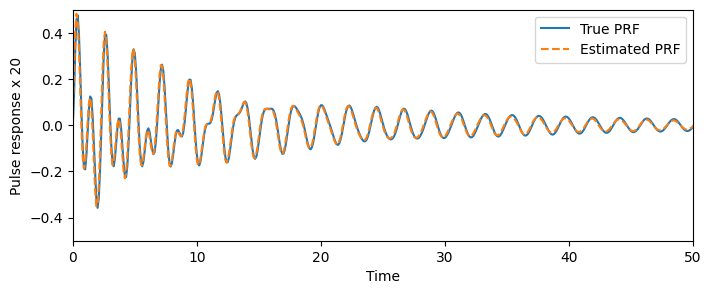

In [20]:
#> Toeplitz matrix constructed from the input data.
T = toeplitz(u, u[:1000])
print("Dimensions of the over-determined system : ", T.shape)

#> Solve the least-squares problem.
h, *_ = np.linalg.lstsq(T, y)

#> Plot the identified PRF and the actual one.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(np.arange(0, len(prf))*Δt, prf*20, label="True PRF")
ax.plot(np.arange(0, len(h))*Δt, h*20, ls="--", label="Estimated PRF")
ax.legend(loc=0)
ax.set(xlim=(0, 50), xlabel="Time")
ax.set(ylim=(-0.5, 0.5), ylabel="Pulse response x 20")

Clearly, a pretty good match is obtained. Note that we've used a very simple least-squares solver which do not leverage the Toeplitz structure of the problem and thus does not scale very well as we increase the number of elements of the convolution kernel we'd like to infer. Nonetheless, we can use this bit of the pulse response function as an input for ERA. This is done below.

In [21]:
#> Runs the identification procedure.
order = 4
era_sys_bis, hsvd = ERA(h, order, dt=Δt, nr=100, nc=100)

[(0.0, 1.0), Text(0.5, 0, 'Frequency [Hz]')]

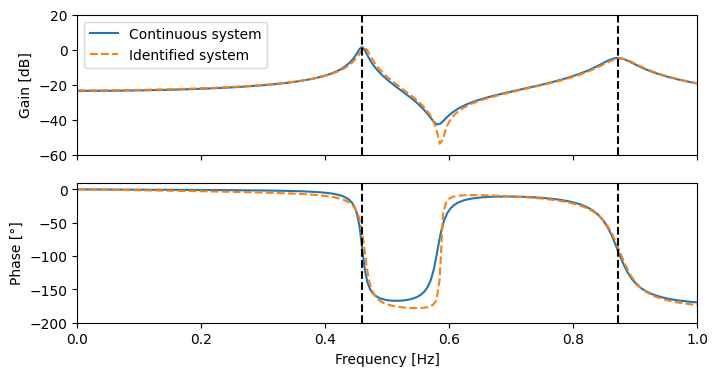

In [22]:
#> Bode plot of the identified system.
ω_discrete, magnitude_discrete, φ_discrete = era_sys_bis.bode(w=ω)

#> Plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(ω/(2*np.pi), magnitude, label="Continuous system")
axes[0].plot(ω_discrete / (2*np.pi), magnitude_discrete, ls="--", label="Identified system")
axes[0].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[0].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[0].set(ylim=(-60, 20), ylabel="Gain [dB]")
axes[0].legend(loc=0)

axes[1].plot(ω/(2*np.pi), φ)
axes[1].plot(ω_discrete/(2*np.pi), φ_discrete, ls="--")
axes[1].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[1].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[1].set(ylim=(-200, 10), ylabel="Phase [°]")
axes[1].set(xlim=(0, 1), xlabel="Frequency [Hz]")

A reasonnably good fit is obtained once more. The quality of the fit is however expected to improve as we estimate more and more elements of the convolution kernel. As mentioned earlier, this might however require the use a dedicated least-squares solver for the sake of computational performances.

Although practical, the two-step approach just described has two major limitations:
1. The regression problem for the convolution kernel might be sensitive to sensor or process noise (things we haven't considered thus far) and might require some form of regularization in practice.
2. The system identified using ERA will be only as good as our estimate of the impulse response is (which is tied to our first point).

Various approach have been proposed to circumvent these issues, the most efficient and practical one being the combined use of [OKID]() (Observer Kalman Identification) and ERA, see [Juang et al.](https://ntrs.nasa.gov/api/citations/19930009636/downloads/19930009636.pdf) (1993) for an example.

#### **System ID using subspace methods**

The approach we'll use here belongs to the class of [subspace identification methods](https://en.wikipedia.org/wiki/Subspace_identification_method). Recall the *extended state space model*

$$
Y_f - \mathcal{T}_{\tau} U_f = \mathcal{O}_{\tau} A^k \mathcal{O}_{\tau}^{\dagger} Y_p + \mathcal{O}_{\tau} \left( \Delta_{\tau} - A^k \mathcal{O}_{\tau}^{\dagger} \mathcal{T}_{\tau} \right) U_p.
$$

where $U_p$, $U_f$, $Y_p$ and $Y_f$ are Hankel matrices constructed from input-output data. It can be written as

$$
Y_f = \begin{bmatrix} \mathcal{O}_{\tau} \left( \Delta_{\tau} - A^k \mathcal{O}_{\tau}^{\dagger} \mathcal{T}_{\tau} \right) & \mathcal{T}_{\tau} & \mathcal{O}_{\tau} A^k \mathcal{O}_{\tau}^{\dagger} \end{bmatrix} \begin{bmatrix} U_p \\ U_f \\ Y_p \end{bmatrix}.
$$

Let $W = I - U_f^T \left(U_f U_f^T \right)^{-1} U_f$ be the projector onto the orthogonal complement of the row span of $U_f$.
Then

$$
Y_f W \simeq \mathcal{O}_{\tau} \Delta_{\tau} U_p W,
$$

where $\mathcal{O}_{\tau}$ and $\Delta_{\tau}$ are the observability and reversed-controllability matrices introduced at the begining of this notebook. Note that, up to a column permutation, the operator $\mathcal{O}_{\tau} \Delta_{\tau}$ is nothing but the *Hankel* operator and thus has finite rank. It could thus be estimated from the data matrices $Y_f$ and $U_p$ using a reduced-rank regression estimator and, as in ERA, a realization $(A, B, C)$ can easily be constructed from it. The corresponding reduced-rank regression problem reads

$$
\begin{aligned}
    \mathrm{minimize} & \quad \Vert M^{\frac12} \left( Y_f - \mathcal{O}_{\tau}\Delta_{\tau} U_f \right) W^{\frac12} \Vert_F^2 \\
    \mathrm{subject~to} & \quad \mathrm{rank}(\mathcal{O}_{\tau}\Delta_{\tau}) = r,
\end{aligned}
$$

where $r > 0$ is the desired dimension of the estimated LTI system. Here, $M$ is a symmetric positive-definite matrix which induces a weighted Frobenius norm. Different choices of $M$ lead to subspace identification methods with different properties. Two standard approaches are
- $M = I$ leading to MOESP (see [Verhaegan](https://www.sciencedirect.com/science/article/abs/pii/0005109894902291), 1994) which minimizes the prediction error.
- $M = \left( Y_f W Y_f^T \right)^{-1}$ leading to CVA (see [Larimore](https://ieeexplore.ieee.org/document/203665/), 1990) which maximizes the mutual information between the input and output data.

While subspace identification methods also require an input signal with a sufficiently large P.E. order be used, they can easily accomodate additional constraints on the inferred LTI system and can be easily extended to naturally include both stochastic process and sensor noise. Let us now illustrate the subspace ID method on our test problem and compare its performances with the two-step approach discussed previously.

In [23]:
from scipy.linalg import eig, svd
def rrr(X, Y, rank):
    """
    SVD-based algorithm for the reduced-rank estimator (with M = I).
    
    INPUT
    -----
    
    X : numpy array, shape (mx, n)
        Input array.
        
    Y : numpy array, shape (my, n)
        Input array.
        
    rank : integer
           Rank of the estimator.
    """
    Ux, Sx, Vxt = svd(X, full_matrices=False)
    Uy, Sy, Vyt = svd(Y, full_matrices=False)
    
    p, s, _ = svd(np.diag(Sy) @ Vyt @ Vxt.T)
    print("Eigenvalues : ", s[:20])
    p, s = p[:, :rank], s[:rank]
    q = np.linalg.pinv(np.diag(Sx)) @ Vxt @ Vyt.T @ np.diag(Sy) @ p
    
    P, Q = Uy @ p, Ux @ q
    
    return P, Q.T

In [24]:
def subspace_id(u, y, order, nr=1000, dt=1.0):
    """
    Subspace Identification method based on the reduced-rank estimator of the Hankel operator.
    The implementation is specialized for a SISO system.
    
    INPUT
    -----
    
    u : numpy array, shape (n, )
        Time-series of the input.
        
    y : numpy array, shape (n, )
        Time-series of the output.
        
    order : integer
            Order of the system to be identified.
            
    nr : integer, optional
         Number of rows of the Hankel matrices.
         
    dt : float, optional
         Sampling period.
         
    OUTPUT
    ------
    
    sys : scipy.signal.dlti instance
          Identified system.
    """
    
    #> Number of columns of the Hankel matrices.
    k = len(u) - 2*nr
    
    #> Hankel matrices of past and future input.
    Up, Uf = Hankel(u, nr=nr, nc=k), Hankel(u[nr:], nr=nr, nc=k)
    
    #> Hankel matrices of past and future output.
    Yp, Yf = Hankel(y, nr=nr, nc=k), Hankel(y[nr:], nr=nr, nc=k)
    
    #> Extended input to account for Kalman filtering. (not discussed in class)
    Z = np.r_[Yp, Up]
    
    #> Projector onto the orthogonal complement of Uf.
    _, _, Vt = svd(Uf, full_matrices=False) ; V = Vt.T
    
    #> Projected matrices.
    Yf_, Up_ = Yf - np.linalg.multi_dot([Yf, V, V.T]), Z - np.linalg.multi_dot([Z, V, V.T])
        
    #> Generalized eigenvalues problem for the Hankel operator.
    Obs, reversed_Ctrb = rrr(Up_, Yf_, order)
    
    #> Extract state-space realization.
    A = np.linalg.pinv(Obs[:-1]) @ Obs[1:]
    C = Obs[0].reshape(1, -1)
    B = reversed_Ctrb[:, -1].reshape(-1, 1)
    D = np.zeros((1, 1))
        
    #> Identified system.
    sys = dlti(A, B, C, D, dt=dt)
    
    return sys

In [25]:
#> Runs the identification process.
identified_sys = subspace_id(u, y, order, dt=Δt)

Eigenvalues :  [23.25923139 22.51656572 12.89760216 12.20151287  0.80273842  0.80154443
  0.59792281  0.59769415  0.57001711  0.56943494  0.53456325  0.53289824
  0.50582113  0.50525533  0.4631301   0.46268126  0.42485969  0.42378321
  0.37696731  0.3767343 ]


[(0.0, 1.0), Text(0.5, 0, 'Frequency [Hz]')]

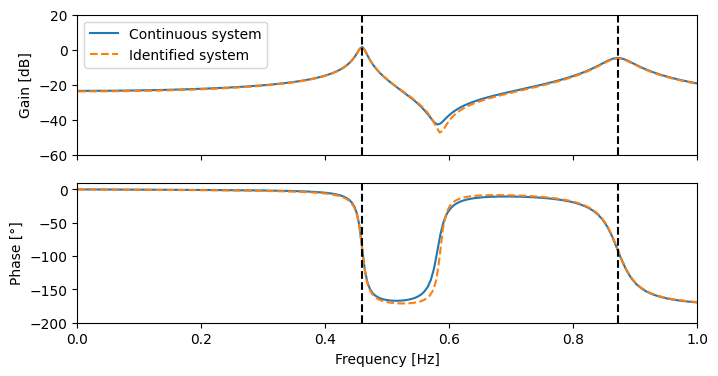

In [26]:
#> Bode plot of the identified system.
ω_discrete, magnitude_discrete, φ_discrete = identified_sys.bode(w=ω)

#> Plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(ω/(2*np.pi), magnitude, label="Continuous system")
axes[0].plot(ω_discrete / (2*np.pi), magnitude_discrete, ls="--", label="Identified system")
axes[0].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[0].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[0].set(ylim=(-60, 20), ylabel="Gain [dB]")
axes[0].legend(loc=0)

axes[1].plot(ω/(2*np.pi), φ)
axes[1].plot(ω_discrete/(2*np.pi), φ_discrete, ls="--")
axes[1].axvline(λ.imag[0] / (2*np.pi), c="k", ls="--")
axes[1].axvline(λ.imag[2] / (2*np.pi), c="k", ls="--")
axes[1].set(ylim=(-200, 10), ylabel="Phase [°]")
axes[1].set(xlim=(0, 1), xlabel="Frequency [Hz]")

[(-0.5, 0.5), Text(0, 0.5, 'Pulse response x 100')]

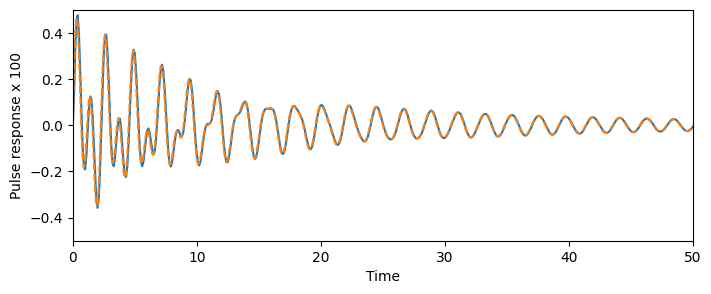

In [27]:
_, prf = dt_plant.impulse(t=t) ; prf = prf[0].flatten()
_, identified_prf = identified_sys.impulse(t=t) ; identified_prf = identified_prf[0].flatten()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, prf*20)
ax.plot(t, identified_prf*20, ls="--")
ax.set(xlim=(0, 50), xlabel=r"Time")
ax.set(ylim=(-0.5, 0.5), ylabel="Pulse response x 100")

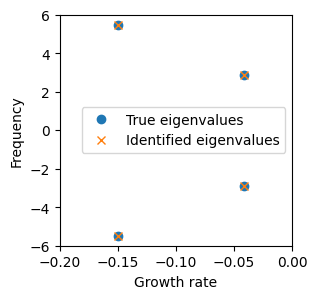

In [28]:
μ = np.log(np.linalg.eigvals(identified_sys.A)) / Δt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(λ.real, λ.imag, "o", label="True eigenvalues")
ax.plot(μ.real, μ.imag, "x", label="Identified eigenvalues")

ax.set(xlim=(-0.2, 0), xlabel="Growth rate")
ax.set(ylim=(-6, 6), ylabel="Frequency")
ax.legend(loc=0)

plt.savefig("identified_eigenspectrum.png", bbox_inches="tight", dpi=1200, transparent=True)

Clearly, the identified system exhibits dynamics very similar to those of the original system. Note however that subspace methods can be quite sensitive to the sampling period, the number of rows of the Hankel matrices, etc. They however form a powerful set of tools which can be extended quite naturally to stochastic systems.

## **Conclusion**

System identification for linear-time-invariant input/output systems is a well established field of applied mathematics with computationally robust and efficient algorithms which can easily be implemented using any language with bindings to [`lapack`](https://www.netlib.org/lapack/) (here via `numpy` and `scipy`). Despite its theoretical restriction to LTI system, these techniques have proven fundational in many control system engineering applications, from simple electrical circuit all the way to mechanical structures as complex as the truss/solar arrays of the space station.

While their most obvious applications is on experimental data, these techniques can also be applied for reduced-order modeling of a numerical model *in lieu* of traditional model-based techniques such as [balanced truncation](https://web.mit.edu/6.242/www/images/lec5_6242_2004.pdf). There are essentially two reasons for this statement:
1. Runing a single impulse response simulation to generate data for ERA might prove more computationally efficient than solving algebraic Lyapunov equations for which we do not currently have algorithms with good scaling properties.
2. Traditional model order reduction techniques often require having access to the *adjoint* system which may not be readily available in many applications. In some cases, it may moreover be very tedious to derive it analytically and even more so to implement it numerically in a consistent way.

It is important to emphasize that, even though they are data-driven, system identification techniques for LTI systems often benefit from very similar theoretical guarantees (notably in term of the Hankel singular values and Hankel norm of the system). They moreover are often used in conjunction with control-oriented algorithms (e.g. LQR, robust control, etc) providing a relatively simple-to-implement data-driven control strategy applicable in a wide variety of engineering applications.

### **To go further**

While we restricted ourselves to deterministic systems, the techniques presented in this notebook can be extended relatively easily to stochastic LTI systems of the form

$$
\begin{aligned}
    x_{t+1} & = Ax_t + Bu_t + w_t \\
    y_t & = Cx_t + Du_t + v_t
\end{aligned}
$$

where $w_t$ and $v_t$ are the process and sensor noise, respectively. Similarly, some of these techniques can be extended to time-varying systems. For more details, you can look at [adaptive control](https://en.wikipedia.org/wiki/Adaptive_control), a notable example being the [least-mean square filter](https://en.wikipedia.org/wiki/Least_mean_squares_filter).

### **Acknowledgements**

This work was made possible thanks to the financial support of the French National Agency for Research (ANR) through the ANR-33-CE46-0008-CONMAN grant agreement.

<img src="https://upload.wikimedia.org/wikipedia/fr/c/c3/Nouveau_logo_ANR_2022.jpg" style="width:256px" >